<a href="https://colab.research.google.com/github/nvvishnu/CS6910-Assignments/blob/main/Assignment2/partA/Assignment2_partA_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras import *
!pip install wandb
import wandb
from wandb.keras import WandbCallback 

     |████████████████████████████████| 2.1MB 18.3MB/s 
     |████████████████████████████████| 102kB 13.2MB/s 
     |████████████████████████████████| 163kB 50.1MB/s 
     |████████████████████████████████| 133kB 56.3MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=b41920d223dc5741afb3d074bb176bc6bffc10f80332c9cbdf4905042256264d
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=74d2fc25967efc8c5e5d4c105729b4d146b60f7e01dd3873845abb814ba3ee31
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Splitting training data into training and validation set in the ratio 9:1 

# # import os
# # path = '/content/drive/MyDrive/nature_12K.zip'
# # import zipfile
# # with zipfile.ZipFile(path, 'rw') as zip_ref:
# #     zip_ref.extractall('/content/drive/MyDrive/Assignment2')
# !pip install split-folders tqdm
# import splitfolders
# splitfolders.ratio(path+'train', output=path+'split', seed=1337, ratio=(.9, .1), group_prefix=None) # default values

In [4]:
path = '/content/drive/MyDrive/Assignment2/inaturalist_12K/' #Load the inaturalist_12K dataset

##simple function which returns the CNN consisting of 5 convolution layers
#filters is a list , where filters[i] indicates num of filters in ith convolutional layer (0 indexing)
#kern_filter is a list of tuples denoting the kernel_size of the filter
#actiavation_fn is a list of activation functions

def simplenetwork(filters,kern_filter,activation_fn,dense_layer_size):
    model = Sequential()
    for i in range(5):
          if(i == 0):
            model.add(layers.Conv2D(filters[i],kern_filter[i],input_shape=(224,224,3),activation=activation_fn[i]))     
          else :
            model.add(layers.Conv2D(filters[i],kern_filter[i],activation=activation_fn[i]))
          model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_layer_size,activation=activation_fn[5]))
    model.add(layers.Dense(10,activation='softmax'))
    return model

In [5]:
model = simplenetwork([32,32,32,32,32],[(3,3),(3,3),(3,3),(3,3),(3,3)],['relu' for i in range(6)],1024)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        9

In [6]:
#More general function where we can add drop_out batch_normalisation , avg_pool etc.
#filters is a list , where filters[i] indicates num of filters in ith convolutional layer (0 indexing)
#kern_filter is a list of tuples denoting the kernel_size of the filter
#actiavation_fn is a list of activation functions
#drop_out is the value of drop_out we will apply
#batch_normalisation if set true we do batch normalisation after each layer
#dense_layer is the size of dense layer
#train is train data
#validation is validation data
#num_classes is the number of output classes , this case we pass 10
#epochs is number of epochs
#drop_batch_dense , if 'both' then we apply dropout followed by batchnormalisation after dense layer , if set 'batch' we do only batch_normalisation after dense layer and if ser 'drop' we apply dropout after dense layer
#last2avg_pool if set true then for last2 Convolutional layers we do avgpool instead of maxpooling
#dp_after_each CNN , if set true then we apply dropout after every ConV layer else we apply dropout only on last2 convolutional layers

def network(filters,kern_filter,activation_fn,drop_out,batch_normalisation,dense_layer,train,validation,num_classes,epochs,drop_batch_dense,last_2_avgpool,dp_aft_eachCNN):
    
     model = Sequential()
     
     if (batch_normalisation):
        for i in range(5):
          if(i == 0):
            model.add(layers.Conv2D(filters[i],kern_filter[i],input_shape=(224,224,3),activation=activation_fn[i]))     
          else :
            model.add(layers.Conv2D(filters[i],kern_filter[i],activation=activation_fn[i]))

          if (i<=2 or not(last_2_avgpool)):
             if(dp_aft_eachCNN or i>2):
                model.add(layers.Dropout(drop_out))
             model.add(layers.BatchNormalization())
             model.add(layers.MaxPooling2D(pool_size=(2,2)))
          else:
             model.add(layers.Dropout(drop_out))
             model.add(layers.BatchNormalization())
             model.add(layers.AveragePooling2D(pool_size=(2, 2)))
     else:
        for i in range(5):
          if(i == 0):
            model.add(layers.Conv2D(filters[i],kern_filter[i],input_shape=(224,224,3),activation=activation_fn[i]))
          else :
            model.add(layers.Conv2D(filters[i],kern_filter[i],activation=activation_fn[i]))
          if(i<=2 or not(last_2_avgpool)):
             if(i>2 or dp_aft_eachCNN):
               model.add(layers.Dropout(drop_out))
             model.add(layers.MaxPooling2D(pool_size=(2,2)))
          else:
             model.add(layers.Dropout(drop_out))
             model.add(layers.AveragePooling2D(pool_size=(2, 2)))

     model.add(layers.Flatten())
     model.add(layers.Dropout(drop_out))
     model.add(layers.BatchNormalization())
     model.add(layers.Dense(dense_layer,activation='relu'))  #activation_fn[5]))
     if(drop_batch_dense == 'both' or drop_batch_dense == 'drop'):
         model.add(layers.Dropout(drop_out))
     if(drop_batch_dense == 'both' or drop_batch_dense == 'batch'):
         model.add(layers.BatchNormalization())
     model.add(layers.Dense(num_classes))
     model.add(layers.Softmax())
     labels = ['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
     print(model.summary())

     model.compile(optimizer='adam',loss=losses.CategoricalCrossentropy(),metrics=['accuracy'])
     model.fit(train,epochs=epochs,validation_data=validation)#,callbacks=[]WandbCallback()])

     return model

In [7]:
#a function for Image processing , this returns generators for the train and validation_data
#data_augmentation if True then we augment the training data
#batch_size is the batch size of data
def ImageProcessing(data_augmentation,batch_size):
    
      augmented = preprocessing.image.ImageDataGenerator(
                              #featurewise_center=True,
                              #featurewise_std_normalization=True,
                              rotation_range=20,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              horizontal_flip=True)
      datagen = preprocessing.image.ImageDataGenerator()
      train = []
      validation = []
      if(data_augmentation):
          train = augmented.flow_from_directory(path+'split/train/',target_size=(224,224),color_mode='rgb', classes=None,class_mode='categorical', batch_size=batch_size)
      else:
          train = datagen.flow_from_directory(path+'split/train/',target_size=(224,224),color_mode='rgb', classes=None,class_mode='categorical', batch_size=batch_size)
      validation = datagen.flow_from_directory(path+'split/val/',target_size=(224,224),color_mode='rgb', classes=None,class_mode='categorical', batch_size=batch_size)

      return (train,validation)

In [8]:
# A function which calls the network function , this function makes ready the train_data and validation data and call the networks function
def CNN(filter,filter_organisation,drop_out,batch_normalisation,data_augmentation,kernel_size,batch_size,epochs,drop_batch_dense,last_2_avgpool,dense_sz,dp_aft_eachCNN):

   (train,validation) = ImageProcessing(data_augmentation,batch_size)
   filters = []
   if(filter_organisation == 'same'):
       filters = [filter for i in range(5)]
   if(filter_organisation == 'half'):
       filters = [filter//(2**i) for i in range(5)]
   if(filter_organisation == 'double'):
       filters = [filter*(2**i) for i in range(5)]

   return network(filters,kernel_size,['relu' for i in range(6)],drop_out,batch_normalisation,dense_sz,train,validation,10,epochs,drop_batch_dense,last_2_avgpool,dp_aft_eachCNN)

In [9]:
# A train_function which wandb calls
def train():
  config_default = { 
        'filter': 16,
        'filter_organisation': 'double',
        'drop_out':0.2,
        'batch_normalisation': True,
        'data_augmentation': True ,
        'kernel_size': [(3,3),(3,3),(5,5),(7,7),(11,11)],
        'batch_size': 32,
        'epochs':10,
        'drop_batch_dense':'both',
        'last_2_avgpool': True,
        'dp_aft_eachCNN' : False,
  }
  print("wand about to be initialised")
  wandb.init(config=config_default,project='Assignment2')
  config = wandb.config

  CNN(config.filter,config.filter_organisation,config.drop_out,config.batch_normalisation,config.data_augmentation,config.kernel_size,config.batch_size,config.epochs,config.drop_batch_dense,config.last_2_avgpool,config.dense_sz,config.dp_aft_eachCNN)
  

In [10]:
#sweep configuration
sweep_config = {
    'name': 'CNN',
    'method' : 'bayes',
    'metric': {        
         'goal': 'maximize',
         'name' : 'val_accuracy'
    },
    'parameters': {
        'filter':{
            'values': [32,64]
        },
        'filter_organisation':{
             'values':['double','same','half']
        },
        'drop_out':{
             'values':[0.2,0.3]
        },
        'batch_normalisation':{
            'values':[True,False]
        },
        'data_augmentation':{
            'values':[True,False]
        },
        'kernel_size':
        {
            'values':[[(3,3),(3,3),(3,3),(3,3),(3,3)],[(3,3),(3,3),(5,5),(7,7),(7,7)],[(11,11),(5,5),(7,7),(3,3),(3,3)]]
        },
        'batch_size':
        {
            'values':[32,64]
        },
        'epochs':
        {
            'values':[25,30]
        },
        'drop_batch_dense':
        {
            'values' : ['both','drop','batch']
        },
        'last_2_avgpool':
        {
            'values':[True,False]
        },
        'dense_sz':
        {
            'values':[128,256,1024]
        },
        'dp_aft_eachCNN':
        {
            'values' : [True,False]
        }
    }
}

In [11]:
#sweep_id = wandb.sweep(sweep_config,entity="shivaram_22",project="Assignment2")

In [12]:
#wandb.agent(sweep_id,project="Assignment2",function=train)

In [14]:
#CNN(config.filter,config.filter_organisation,config.drop_out,config.batch_normalisation,config.data_augmentation,config.kernel_size,config.batch_size,config.epochs,config.drop_batch_dense,config.last_2_avgpool,config.dense_sz,config.dp_aft_eachCNN)  
#collecting the model of the best hyperparameter configuration
model = CNN(32,'double',0.2,True,True,[(3,3),(3,3),(5,5),(7,7),(7,7)],64,25,'both',True,1024,False)

Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 64)        0         
__________________________________

In [15]:
#applying the model on test data
datagen = preprocessing.image.ImageDataGenerator()
print(path+'val/')
test = validation = datagen.flow_from_directory(path+'val/',target_size=(224,224),color_mode='rgb', classes=None,class_mode='categorical')

/content/drive/MyDrive/Assignment2/inaturalist_12K/val/
Found 2000 images belonging to 10 classes.


In [16]:
m = model.evaluate(test,return_dict=True)

63/63 [==============================] - 819s 13s/step - loss: 2.0500 - accuracy: 0.3820


In [17]:
!pip install h5py
#Saving the best model as json and h5 files
from keras.models import model_from_json
from tensorflow.keras import *
model_path = '/content/drive/MyDrive/Assignment2/'
# reffered this for saving and loading the model 'https://machinelearningmastery.com/save-load-keras-deep-learning-models/'

# model_json = model.to_json()
# with open(model_path+"model.json", "w") as json_file:
#     json_file.write(model_json)

# model.save_weights(model_path+"model.h5")
# print("Saved model to disk")

#Loading the model from disk
json_file = open(model_path+'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(model_path+"model.h5")
print("Loaded model from disk")
loaded_model.summary()
#recompiling the loaded model
loaded_model.compile(optimizer='adam',loss=losses.CategoricalCrossentropy(),metrics=['accuracy'])
model = loaded_model

Loaded model from disk
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (Non

In [18]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

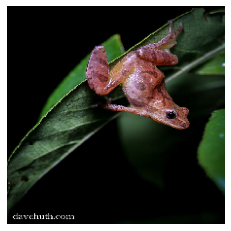

In [19]:
img_path = "/content/drive/MyDrive/Assignment2/inaturalist_12K/val/Amphibia/06369a70c92e4c9ae1ece6f2ba889a6c.jpg"
input_img = image.load_img(img_path,target_size=(224,224))
plt.imshow(input_img)
plt.axis("off");
#wandb.log({'Input_Image':[wandb.Image(input_img,caption='sample_image')]})
input_img = image.img_to_array(input_img)
input_img = preprocess_input(np.expand_dims(input_img, axis=0))

#helper function to normalise input tensor with mean 0 , variance 0.25 and converting it into rgb
def g(x):
   x = (x-x.mean())
   x = x/(x.std()+K.epsilon())
   x = x*(0.25)
   x = np.clip(x+0.5,0,1)*255
   x = np.clip(x,0,255).astype('uint8')
   return x

In [20]:
##code for guided backpropoagation
import random
#referred to this 'https://stackoverflow.com/questions/55924331/how-to-apply-guided-backprop-in-tensorflow-2-0' to understand the details in implementing guided back_prop in tensorflow.
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

images = []
labels = []

for ii in range(10):
    x = random.randint(0,512*9)
    i = x//(512*3)
    x -= i*(512*3)
    j = x//(512)
    x -= j*(512)
    k = x
    mask = np.zeros(shape=(1,3,3,512))
    mask[0][i][j][k] = 1
    #print(i,j,k)
    model = loaded_model
    gb_model = Model(
        inputs = [model.inputs],
        outputs = [model.get_layer("conv2d_4").output]
    )

    layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu
    
    with tf.GradientTape() as tape:
      inputs = tf.cast(input_img, tf.float32)
      tape.watch(inputs)
      outputs = gb_model(inputs)*mask

    grads = tape.gradient(outputs,inputs)[0]
    labels.append('neuron: ('+str(i)+','+str(j)+','+str(k)+')')
    images.append(np.flip(g(np.array(grads)),-1))

print(len(images))
# !wandb login 
# wandb.init(project="Assignment2", entity="shivaram_22")
# wandb.log({"Guided backpropoagation on randomly choosen 10 neurons from conv5 layer": [wandb.Image(image,caption=label) for image,label in zip(images,labels)]})

10


In [21]:
#code for filter visualisation: 
v_model = Model(inputs = [model.inputs],outputs = [model.get_layer("conv2d").output])
inputs = tf.cast(input_img, tf.float32)
outputs = v_model(inputs)

In [22]:
f_out = outputs[0].numpy()
images = []
labels = []
for i in range(32):
  f = f_out[:,:,i]
  f = (f-f.min())/(f.max()-f.min())
  images.append(f)
  labels.append('filter: '+str(i))

#wandb.log({"Filter Visualisation": [wandb.Image(image,caption=label) for image,label in zip(images,labels)]})

In [23]:
#output of weights of 32 filters in conv2d
filters,biases = model.get_layer('conv2d').get_weights()
filters = (filters-filters.min())/(filters.max()-filters.min())
images = []
labels = []
for i in range(32):
    #print('filter_num: ',i)
    f = filters[:,:,:,i]
    images.append(f)
    labels.append('filter: '+str(i))

#wandb.log({"Filter weights Visualisation": [wandb.Image(image,caption=label) for image,label in zip(images,labels)]})

In [24]:
#code for prediction on few random imgaes on test data
import os
import random
import numpy as np

path = '/content/drive/MyDrive/Assignment2/inaturalist_12K/val/'
classes = ['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

datagen = preprocessing.image.ImageDataGenerator()
path = '/content/drive/MyDrive/Assignment2/inaturalist_12K/'
test = datagen.flow_from_directory(path+'val/',target_size=(224,224),color_mode='rgb', classes=None,class_mode='categorical',shuffle=False)
Y_pred = model.predict(test)
y_pred = np.argmax(Y_pred, axis=1)

Found 2000 images belonging to 10 classes.


In [25]:

path = '/content/drive/MyDrive/Assignment2/inaturalist_12K/val/'
images = []
labels = []
random.seed(3)
for i in range(10):
    l = os.listdir(path+'/'+classes[i]+'/')
    g = []
    for ii in range(3):
      g.append(random.randint(0,199))
    gg = []
    for x in g:
      img = image.load_img(path+'/'+classes[i]+'/'+l[x], target_size=(224, 224))
      images.append(img)
      pred = y_pred[i*200+x]
      label = 'True:'+classes[i]+",Predicted:"+classes[pred]
      labels.append(label)
      gg.append(pred)
    print('true: ',i,'predicted: ',gg)
    

true:  0 predicted:  [8, 6, 9]
true:  1 predicted:  [8, 9, 6]
true:  2 predicted:  [3, 2, 6]
true:  3 predicted:  [6, 5, 3]
true:  4 predicted:  [8, 8, 4]
true:  5 predicted:  [5, 6, 5]
true:  6 predicted:  [3, 6, 6]
true:  7 predicted:  [6, 6, 7]
true:  8 predicted:  [8, 8, 8]
true:  9 predicted:  [6, 6, 9]


In [26]:
#applying the model on test data
# !wandb login 
# wandb.init(project="Assignment2", entity="shivaram_22")
#wandb.log({"Sample Predictions on test set ": [wandb.Image(image,caption=label) for image,label in zip(images,labels)]})